# Analysis: Linear Store Price

Goal: Use linear regression to create a model for store price.   

Difference: Remove <u>year</u> and <u>number of colors</u> feature due to high colinearity, and over-fitting. 

In [1]:
import pandas as PD
import numpy as NP
import sklearn.preprocessing as PP
import sklearn.model_selection as MS
import sklearn.linear_model as LM
import statsmodels.stats as ST  
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import matplotlib.pyplot as MP
import seaborn as SB
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
%load_ext autoreload
%autoreload 2         # reload custom py file eveytime a new cell is run

#import helper 

## Prepare Target & Features

In [4]:
FULL_FILE = 'data/brickset_features.csv'
full_df = PD.read_csv(FULL_FILE)
full_df.head()
full_df.info()

,set_no,name,price_store,price_used,popularity,group,year,total_parts,number_parts,number_colors,scolor_1st,scolor_2nd
0,1591-1,Danone Delivery Truck,NaN,28.0,NaN,Modern day,1980.0,40,19,4,White,Blue
1,1592-1,Town Square - Castle Scene,NaN,235.0,19.2,Modern day,1980.0,495,133,10,Black,Yellow
2,1651-2,Maersk Line Container Lorry,NaN,444.0,5.0,Modern day,1980.0,305,66,9,Blue,Gray
3,6305-1,Trees and Flowers,3.75,10.0,17.2,Modern day,1980.0,24,6,4,Green,Red
4,6306-1,Road Signs,2.50,13.0,12.0,Modern day,1980.0,12,10,1,White,White


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 12 columns):
set_no           3213 non-null object
name             3213 non-null object
price_store      2762 non-null float64
price_used       3140 non-null float64
popularity       3001 non-null float64
group            3213 non-null object
year             3213 non-null float64
total_parts      3213 non-null int64
number_parts     3213 non-null int64
number_colors    3213 non-null int64
scolor_1st       3213 non-null object
scolor_2nd       3213 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 301.3+ KB


In [5]:
# filter out rows without store price

full_df = full_df.loc[full_df['price_store'].isna()==False]
full_df.shape

(2762, 12)

In [6]:
# target series

target_sr = full_df['price_store']
target_sr.shape

(2762,)

In [7]:
# feature dataframe with one-hot encoding
# remove the 'year', 'number_colors' columns

feature_ls = ['group', 'total_parts', 'number_parts', 'scolor_1st', 'scolor_2nd']
feature_cat_df = full_df[feature_ls]

feature_df = PD.get_dummies(feature_cat_df, drop_first= True, 
               columns=['group', 'scolor_1st', 'scolor_2nd'])
feature_df.shape
feature_df.columns

(2762, 25)

Index(['total_parts', 'number_parts', 'group_Historical', 'group_Licensed',
       'group_Model making', 'group_Modern day', 'group_Racing',
       'scolor_1st_Blue', 'scolor_1st_Brown', 'scolor_1st_Gray',
       'scolor_1st_Green', 'scolor_1st_Red', 'scolor_1st_Tan',
       'scolor_1st_Transparent', 'scolor_1st_White', 'scolor_1st_Yellow',
       'scolor_2nd_Blue', 'scolor_2nd_Brown', 'scolor_2nd_Gray',
       'scolor_2nd_Green', 'scolor_2nd_Red', 'scolor_2nd_Tan',
       'scolor_2nd_Transparent', 'scolor_2nd_White', 'scolor_2nd_Yellow'],
      dtype='object')

In [8]:
# check for colinearity

ST.outliers_influence.variance_inflation_factor
vif = [VIF(feature_df.values, i) for i in range(feature_df.shape[1])]
list(zip(feature_df.columns, vif))

<function statsmodels.stats.outliers_influence.variance_inflation_factor(exog, exog_idx)>

[('total_parts', 4.433934028310383),
 ('number_parts', 6.887089077476057),
 ('group_Historical', 1.3491566821114958),
 ('group_Licensed', 2.561190662701011),
 ('group_Model making', 1.6259609737746992),
 ('group_Modern day', 2.3252573728584562),
 ('group_Racing', 1.1731720854572905),
 ('scolor_1st_Blue', 1.0878867571631474),
 ('scolor_1st_Brown', 1.1653692190822702),
 ('scolor_1st_Gray', 1.7365543171656348),
 ('scolor_1st_Green', 1.036948695507344),
 ('scolor_1st_Red', 1.1735778948772506),
 ('scolor_1st_Tan', 1.1274488720274611),
 ('scolor_1st_Transparent', 1.0039604652098357),
 ('scolor_1st_White', 1.601512703816734),
 ('scolor_1st_Yellow', 1.132400176590232),
 ('scolor_2nd_Blue', 1.1032234345988707),
 ('scolor_2nd_Brown', 1.1497066295434029),
 ('scolor_2nd_Gray', 2.3015703061515933),
 ('scolor_2nd_Green', 1.051638162809334),
 ('scolor_2nd_Red', 1.2841089803486074),
 ('scolor_2nd_Tan', 1.1523476813146032),
 ('scolor_2nd_Transparent', 1.030243643718401),
 ('scolor_2nd_White', 1.4055272

## Split Test & Standardize

In [9]:
TEST_SPLIT = 0.2
SEED = 1

In [10]:
# not able to stratify the subsets 

stratify_sr = target_sr.value_counts()
stratify_sr = stratify_sr[stratify_sr > 1]
stratify_sr.head()
stratify_sr.shape

19.99    210
29.99    165
9.99     145
39.99    142
49.99    140
Name: price_store, dtype: int64

(129,)

In [11]:
y_train, y_test, X_train, X_test = MS.train_test_split(target_sr, feature_df, 
                                                       test_size=TEST_SPLIT, random_state=SEED)

y_train.shape
y_test.shape 
X_train.shape
X_test.shape

(2209,)

(553,)

(2209, 25)

(553, 25)

In [12]:
# fit the scalers based on the training set
# must include all features, including one-hot encoded ones
# target variable does not need to be transformed

scaler = PP.StandardScaler()
scaler.fit(X_train)
scaler.mean_.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

(25,)

In [13]:
# create standardized feature sets

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std.shape

(2209, 25)

[Text(0, 0.5, 'Number of Sets'), Text(0.5, 0, 'Total Parts')]

[Text(0, 0.5, 'Number of Sets'), Text(0.5, 0, 'Standard Total Parts')]

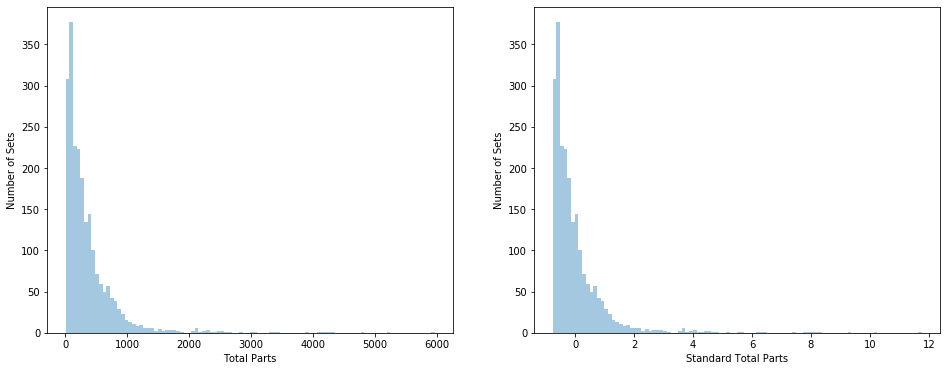

In [14]:
fig, axs = MP.subplots(1, 2, figsize=(16, 6))
parts_idx = X_train.columns.get_loc('total_parts')

SB.distplot(X_train['total_parts'], ax=axs[0], kde=False, bins=100)
axs[0].set(xlabel='Total Parts', ylabel='Number of Sets')

SB.distplot(X_train_std[:, parts_idx], ax=axs[1], kde=False, bins=100)
axs[1].set(xlabel='Standard Total Parts', ylabel='Number of Sets')

MP.show()

## Setup Algorithm

In [15]:
algorithm_ls = []
alpha_ls = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

def get_adjusted_rsquared(rsquared, size, num_cols):
    adj_rsq = 1 - (1 - rsquared) * (size -1) / (size - num_cols -1)
    return adj_rsq

### Vanilla Linear

In [16]:
# get main result
# can't use test set until model is chosen

linreg = LM.LinearRegression()
linreg.fit(X_train_std, y_train)
linreg.coef_.shape
linreg.intercept_.shape

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(25,)

()

In [17]:
train_score = linreg.score(X_train_std, y_train)
train_score_adj = get_adjusted_rsquared(train_score, X_train_std.shape[0], X_train_std.shape[1])
train_score_adj

0.8815056673979644

In [18]:
# use cross validation to get error

cv_results = MS.cross_validate(LM.LinearRegression(), X_train_std, y_train, cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.02096319, 0.01014304, 0.00762177, 0.0034287 , 0.00217509]),
 'score_time': array([0.00623107, 0.0020678 , 0.0015192 , 0.00086999, 0.00110888]),
 'test_score': array([0.88508041, 0.87988614, 0.87405106, 0.87055154, 0.87133989]),
 'train_score': array([0.88145711, 0.88214358, 0.88463742, 0.88485626, 0.88498111])}

In [19]:
# compile algorithm results
# ok to use non-adjusted r-sq, use adjusted just for final test

new_dx = {
    'type': 'baseline',
    'lambda': NP.min(alpha_ls) - 0.5 *NP.min(alpha_ls), 
    'cvtrain_score': cv_results['train_score'].mean(),
    'cvtrain_error': cv_results['train_score'].std(),
    'cvtest_score': cv_results['test_score'].mean(),
    'cvtest_error': cv_results['test_score'].std(),
}
algorithm_ls.append(new_dx)
new_dx

{'type': 'baseline',
 'lambda': 5e-05,
 'cvtrain_score': 0.8836150936845378,
 'cvtrain_error': 0.0015015904497413858,
 'cvtest_score': 0.8761818053831005,
 'cvtest_error': 0.005524335891130545}

### LASSO

In [20]:
lasso = LM.Lasso(alpha=1)
lasso.fit(X_train_std, y_train)
lasso.coef_.shape
lasso.intercept_.shape

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

(25,)

()

In [21]:
train_score = lasso.score(X_train_std, y_train)
train_score

0.8783109530448258

In [22]:
for alp in alpha_ls:
    
    lasso_cv = LM.Lasso(alpha=alp)
    cv_results = MS.cross_validate(lasso_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'lasso',
        'lambda': alp - 0.2 * alp,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)


### Ridge

In [23]:
ridge = LM.Ridge(alpha=1)
ridge.fit(X_train_std, y_train)
ridge.coef_.shape
ridge.intercept_.shape

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

(25,)

()

In [24]:
train_score = ridge.score(X_train_std, y_train)
train_score

0.8828470453662649

In [25]:
for alp in alpha_ls:
    
    ridge_cv = LM.Ridge(alpha=alp)
    cv_results = MS.cross_validate(ridge_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'ridge',
        'lambda': alp,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

### Evaluate Results

In [26]:
algorithm_df = PD.DataFrame(algorithm_ls)
algorithm_df.head()
algorithm_df.info()

,cvtest_error,cvtest_score,cvtrain_error,cvtrain_score,lambda,type
0,0.005524,0.876182,0.001502,0.883615,0.00005,baseline
1,0.005525,0.876182,0.001502,0.883615,0.00008,lasso
2,0.005529,0.876186,0.001502,0.883615,0.00080,lasso
3,0.005577,0.876227,0.001502,0.883612,0.00800,lasso
4,0.006161,0.876363,0.001506,0.883410,0.08000,lasso


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 6 columns):
cvtest_error     17 non-null float64
cvtest_score     17 non-null float64
cvtrain_error    17 non-null float64
cvtrain_score    17 non-null float64
lambda           17 non-null float64
type             17 non-null object
dtypes: float64(5), object(1)
memory usage: 896.0+ bytes


In [27]:
InteractiveShell.ast_node_interactivity = 'last'

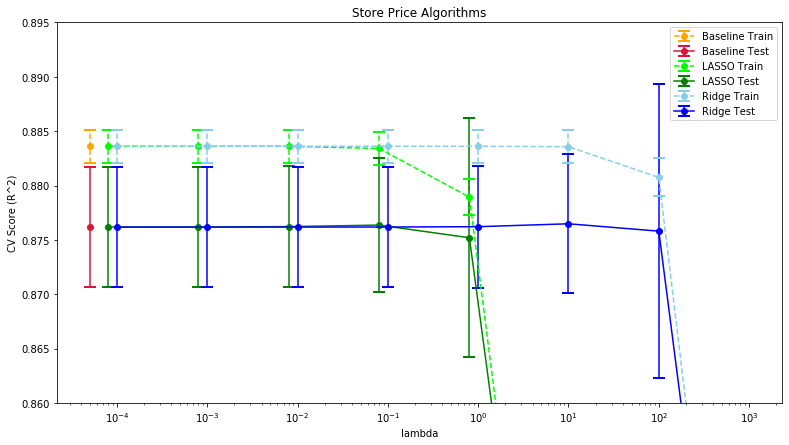

In [28]:
fig, axs = MP.subplots(1, 1, figsize=(13, 7))

baseline_df = algorithm_df.loc[algorithm_df['type']=='baseline']
ebc = axs.errorbar(x=baseline_df['lambda'], y=baseline_df['cvtrain_score'], yerr=baseline_df['cvtrain_error'],
             color='orange', label='Baseline Train', marker='o',capsize=6, capthick=2, linestyle='--')
ebc[-1][0].set_linestyle('--')
axs.errorbar(x=baseline_df['lambda'], y=baseline_df['cvtest_score'], yerr=baseline_df['cvtest_error'],
             color='crimson', label='Baseline Test', marker='o',capsize=6, capthick=2)

lasso_df = algorithm_df.loc[algorithm_df['type']=='lasso']
ebc = axs.errorbar(x=lasso_df['lambda'], y=lasso_df['cvtrain_score'], yerr=lasso_df['cvtrain_error'],
             color='lime', label='LASSO Train', marker='o',capsize=6, capthick=2, linestyle='--')
ebc[-1][0].set_linestyle('--')
axs.errorbar(x=lasso_df['lambda'], y=lasso_df['cvtest_score'], yerr=lasso_df['cvtest_error'],
             color='green', label='LASSO Test', marker='o',capsize=6, capthick=2)

ridge_df = algorithm_df.loc[algorithm_df['type']=='ridge']
ebc = axs.errorbar(x=ridge_df['lambda'], y=ridge_df['cvtrain_score'], yerr=ridge_df['cvtrain_error'],
             color='skyblue', label='Ridge Train', marker='o',capsize=6, capthick=2, linestyle='--')
ebc[-1][0].set_linestyle('--')
axs.errorbar(x=ridge_df['lambda'], y=ridge_df['cvtest_score'], yerr=ridge_df['cvtest_error'],
             color='blue', label='Ridge Test', marker='o',capsize=6, capthick=2)

axs.set(title='Store Price Algorithms', xlabel='lambda', ylabel='CV Score (R^2)', xscale='log', ylim=(0.86, 0.895))
axs.set_xticks(alpha_ls)
MP.legend()
MP.show()

## Choose Best Algorithm

In [29]:
InteractiveShell.ast_node_interactivity = 'all'

In [30]:
best_df = algorithm_df.loc[algorithm_df['cvtest_score']==algorithm_df['cvtest_score'].max()]
best_df

,cvtest_error,cvtest_score,cvtrain_error,cvtrain_score,lambda,type
14,0.006375,0.876484,0.001506,0.883574,10.0,ridge


In [31]:
algorithm = LM.Ridge(alpha=10)
algorithm.fit(X_train_std, y_train)
algorithm.coef_.shape
algorithm.intercept_

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

(25,)

38.580805794477136

In [32]:
feature_df.columns

Index(['total_parts', 'number_parts', 'group_Historical', 'group_Licensed',
       'group_Model making', 'group_Modern day', 'group_Racing',
       'scolor_1st_Blue', 'scolor_1st_Brown', 'scolor_1st_Gray',
       'scolor_1st_Green', 'scolor_1st_Red', 'scolor_1st_Tan',
       'scolor_1st_Transparent', 'scolor_1st_White', 'scolor_1st_Yellow',
       'scolor_2nd_Blue', 'scolor_2nd_Brown', 'scolor_2nd_Gray',
       'scolor_2nd_Green', 'scolor_2nd_Red', 'scolor_2nd_Tan',
       'scolor_2nd_Transparent', 'scolor_2nd_White', 'scolor_2nd_Yellow'],
      dtype='object')

In [33]:
#beta_year = lasso.coef_[feature_df.columns.get_loc('year')]
beta_total_parts = algorithm.coef_[feature_df.columns.get_loc('total_parts')]
beta_number_parts = algorithm.coef_[feature_df.columns.get_loc('number_parts')]
#beta_number_colors = lasso.coef_[feature_df.columns.get_loc('number_colors')]
beta_group = NP.mean([ algorithm.coef_[feature_df.columns.get_loc('group_Historical')],
                       algorithm.coef_[feature_df.columns.get_loc('group_Licensed')],
                       algorithm.coef_[feature_df.columns.get_loc('group_Model making')],
                       algorithm.coef_[feature_df.columns.get_loc('group_Modern day')],
                       algorithm.coef_[feature_df.columns.get_loc('group_Racing')], ])
beta_scolor_1st = NP.mean([ lasso.coef_[feature_df.columns.get_loc('scolor_1st_Blue')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Brown')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Gray')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Green')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Red')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Tan')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Transparent')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_White')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_1st_Yellow')]  ])
beta_scolor_2nd = NP.mean([ lasso.coef_[feature_df.columns.get_loc('scolor_2nd_Blue')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Brown')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Gray')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Green')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Red')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Tan')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Transparent')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_White')],
                       algorithm.coef_[feature_df.columns.get_loc('scolor_2nd_Yellow')]  ])

In [34]:
#print(f'year: {beta_year: .4f}')
print(f'total_parts: {beta_total_parts: .4f}')
print(f'number_parts: {beta_number_parts: .4f}')
#print(f'number_colors: {beta_number_colors: .4f}')
print(f'group: {beta_group: .4f}')
print(f'scolor_1st: {beta_scolor_1st: .4f}')
print(f'scolor_2nd: {beta_scolor_2nd: .4f}')

total_parts:  33.7837
number_parts:  8.9519
group:  0.7603
scolor_1st: -0.2285
scolor_2nd: -0.3650


In [35]:
algorithm.score(X_test_std, y_test)

0.8323235824769585